In [20]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df_cx = pd.read_csv('../combined_data_binance_ethusdc.csv')
df_dx = pd.read_pickle('data_UV3_WETH_USDC_January2024.pkl')

In [3]:
print('CEX start time:', df_cx.time.iloc[0])
print('CEX final time:', df_cx.time.iloc[-1])
print('DEX start time:', df_dx.time.iloc[-1])
print('DEX final time:', df_dx.time.iloc[0])

CEX start time: 2023-03-12 06:30:00.000
CEX final time: 2024-01-31 23:59:26.240
DEX start time: 2023-12-31 20:50:23
DEX final time: 2024-01-31 23:59:59


If is_buyer_maker is True, it means the buyer in the trade placed an order that was already on the order book, and thus, they are considered the maker. This typically means the buyer placed a limit order that was filled by a taker's market order or an opposing limit order.

If is_buyer_maker is False, it means the buyer in the trade was the taker, meaning they filled an existing order placed by someone else (the maker).

In [4]:
df_cx['time'] = pd.to_datetime(df_cx['time'])

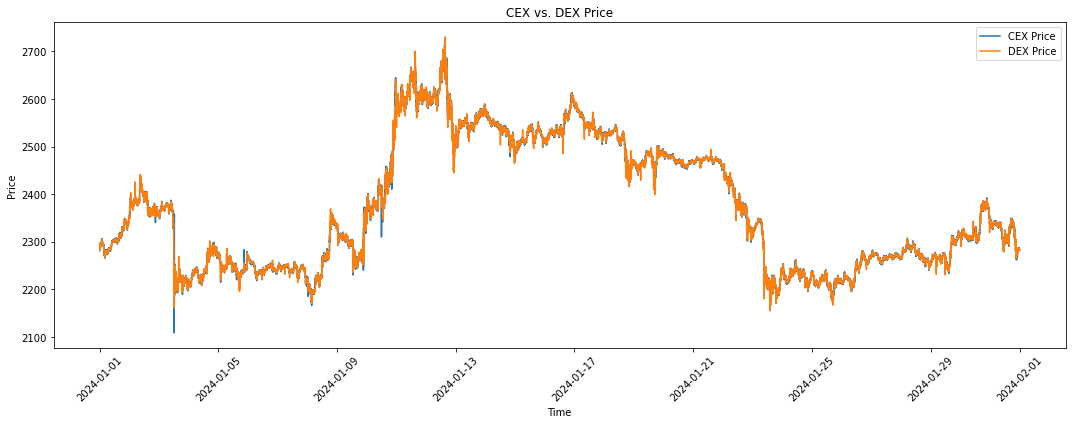

In [5]:
start_time = pd.to_datetime('2024-01-01 00:00:00')
end_time = pd.to_datetime('2024-01-31 23:59:59')
df_cex_f = df_cx[(df_cx['time'] >= start_time) & (df_cx['time'] <= end_time)]
df_dex_f = df_dx[(df_dx['time'] >= start_time) & (df_dx['time'] <= end_time)]

plt.figure(figsize=(15, 6))

plt.plot(df_cex_f['time'], df_cex_f['price'], label='CEX Price')
plt.plot(df_dex_f['time'], df_dex_f['price'], label='DEX Price')

plt.title('CEX vs. DEX Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [6]:
len(df_dx)

188000

# Measuring LVR: arbitrage profits due to stale AMM prices

### Writing all in 1 dataframe for easeness of calculation

In [7]:
df = df_cex_f.copy()
df_dex_f = df_dex_f.sort_values(by='time',ascending=True)
df_dex_f.reset_index(drop=True, inplace = True)

In [14]:
merged_df = pd.merge_asof(df, df_dex_f[['time', 'price']], on='time', direction='forward', allow_exact_matches=False)

# Rename columns to match your output requirement
merged_df.rename(columns={'time_x': 'time_dex', 'price_y': 'price_dex'}, inplace=True)

In [15]:
merged_df

,trade ID,price_x,qty,base_qty,time,is_buyer_maker,Unnamed: 6,price_dex
0,33165689,2281.65,0.0888,202.610520,2024-01-01 00:00:03.953,False,True,2280.878682
1,33165690,2281.38,0.0060,13.688280,2024-01-01 00:00:12.961,True,True,2280.878682
2,33165691,2281.19,1.0789,2461.175891,2024-01-01 00:00:12.961,True,True,2280.878682
3,33165692,2281.19,0.1851,422.248269,2024-01-01 00:00:12.962,True,True,2280.878682
4,33165693,2281.19,0.5748,1311.228012,2024-01-01 00:00:12.962,True,True,2280.878682
...,...,...,...,...,...,...,...,...
786017,33951706,2281.43,0.1201,273.999743,2024-01-31 23:58:46.318,True,True,2281.791170
786018,33951707,2281.43,0.2191,499.861313,2024-01-31 23:58:46.380,True,True,2281.791170
786019,33951708,2281.49,0.0365,83.274385,2024-01-31 23:59:01.498,True,True,2281.563014
786020,33951709,2281.51,0.0888,202.598088,2024-01-31 23:59:08.297,False,True,2281.563014


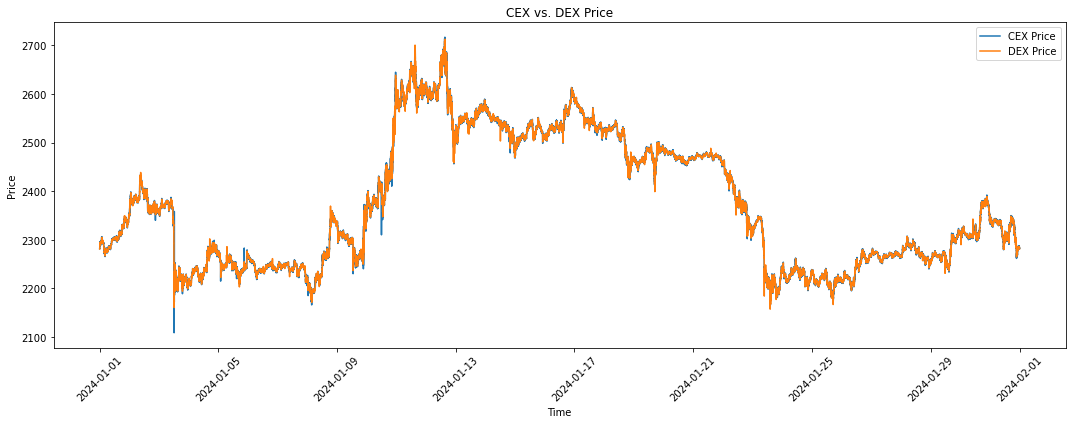

In [13]:
plt.figure(figsize=(15, 6))

plt.plot(merged_df['time'], merged_df['price_x'], label='CEX Price')
plt.plot(merged_df['time'], merged_df['price_y'], label='DEX Price')

plt.title('CEX vs. DEX Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
#df['time_dex'] = None
#df['price_dex'] = None
#last_pos = 0

#for index, row in df_dex_f.iterrows():
#    idx_time = row['time']
#    idx_price = row['price']
#    for cex_index in range(last_pos, len(df)):
#        if df.iloc[cex_index]['time'] < idx_time:
#            df.at[cex_index, 'time_dex'] = idx_time
#            df.at[cex_index, 'price_dex'] = idx_time
#        else:
#            last_pos = cex_index
#            break

In [16]:
merged_df['LVR'] = merged_df['price_x'] - merged_df['price_dex']
merged_df['LVR_cumm'] = merged_df['LVR'].abs().cumsum()
merged_df

,trade ID,price_x,qty,base_qty,time,is_buyer_maker,Unnamed: 6,price_dex,LVR,LVR_cumm
0,33165689,2281.65,0.0888,202.610520,2024-01-01 00:00:03.953,False,True,2280.878682,0.771318,0.771318
1,33165690,2281.38,0.0060,13.688280,2024-01-01 00:00:12.961,True,True,2280.878682,0.501318,1.272636
2,33165691,2281.19,1.0789,2461.175891,2024-01-01 00:00:12.961,True,True,2280.878682,0.311318,1.583954
3,33165692,2281.19,0.1851,422.248269,2024-01-01 00:00:12.962,True,True,2280.878682,0.311318,1.895271
4,33165693,2281.19,0.5748,1311.228012,2024-01-01 00:00:12.962,True,True,2280.878682,0.311318,2.206589
...,...,...,...,...,...,...,...,...,...,...
786017,33951706,2281.43,0.1201,273.999743,2024-01-31 23:58:46.318,True,True,2281.791170,-0.361170,968173.178132
786018,33951707,2281.43,0.2191,499.861313,2024-01-31 23:58:46.380,True,True,2281.791170,-0.361170,968173.539303
786019,33951708,2281.49,0.0365,83.274385,2024-01-31 23:59:01.498,True,True,2281.563014,-0.073014,968173.612317
786020,33951709,2281.51,0.0888,202.598088,2024-01-31 23:59:08.297,False,True,2281.563014,-0.053014,968173.665331


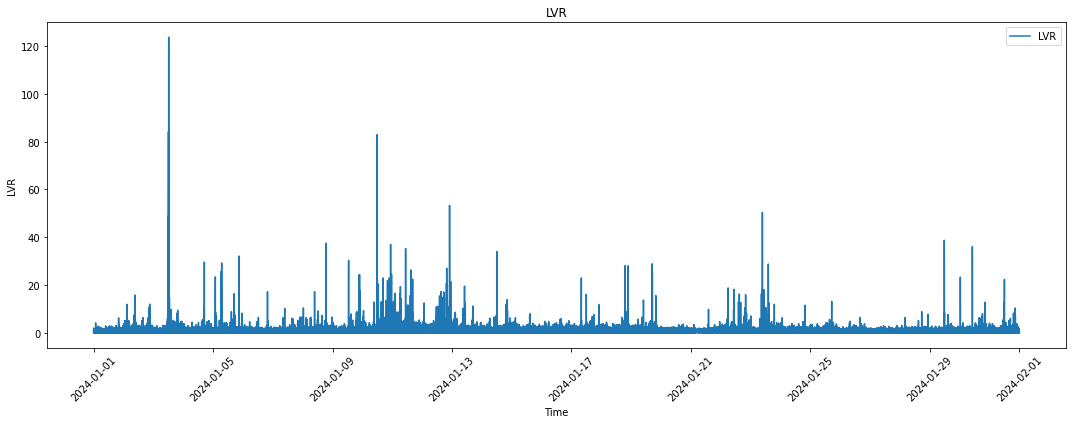

In [22]:
plt.figure(figsize=(15, 6))

plt.plot(merged_df['time'], merged_df['LVR'].abs(), label='LVR')

plt.title('LVR')
plt.xlabel('Time')
plt.ylabel('LVR')
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

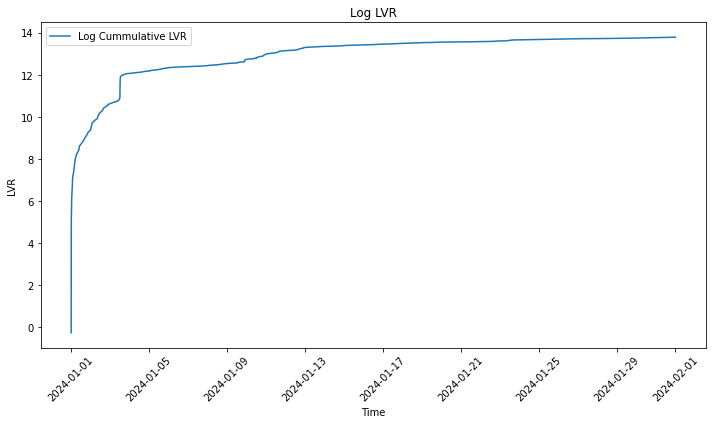

In [24]:
plt.figure(figsize=(10, 6))

plt.plot(merged_df['time'], np.log(merged_df['LVR_cumm']), label='Log Cummulative LVR')

plt.title('Log LVR')
plt.xlabel('Time')
plt.ylabel('LVR')
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

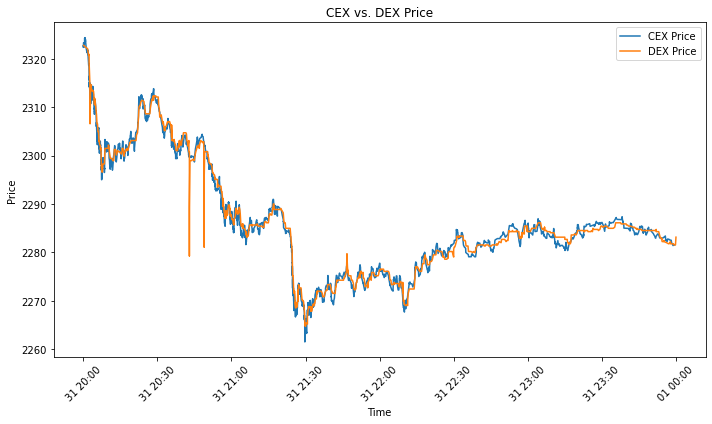

In [26]:
start_time = pd.to_datetime('2024-01-31 20:00:00')
end_time = pd.to_datetime('2024-01-31 23:59:59')
df_cex_f = df_cx[(df_cx['time'] >= start_time) & (df_cx['time'] <= end_time)]
df_dex_f = df_dx[(df_dx['time'] >= start_time) & (df_dx['time'] <= end_time)]

plt.figure(figsize=(10, 6))

plt.plot(df_cex_f['time'], df_cex_f['price'], label='CEX Price')
plt.plot(df_dex_f['time'], df_dex_f['price'], label='DEX Price')

plt.title('CEX vs. DEX Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()
